Version notes:
- value-weighting
- need to remove bonds which do not have returns on consecutive months (or go back and see why this is) (Example: issue id 5)

# ML Analysis

In [6]:
import pandas as pd
import numpy as np

## Data
Data are from 'data_cleaning.ipynb', which uses a subset of merged TRACE and Mergent FISD daily bond data. It follows the sample exclusion criteria of Bai, Bali & Wen (2019) and aggregates returns to monthly based on their methodologies.

In [7]:
data = pd.read_csv('monthly_data.csv', index_col=0)

In [8]:
data.head()

,date,issue_id,cusip_id,volume,issuer_id,prospectus_issuer_name,maturity,offering_amt,interest_frequency,cusip,...,rating_spr,rating_mdy,amount_outstanding,tau,age,ytm,duration,tr_dirty_price,tr_ytm,return
0,2002-08-31,98694,010392DN5,25000.0,86.0,ALABAMA PWR CO,2004-08-15,250000.0,2.0,010392DN5,...,A,A2,250000.0,1.972603,3.038356,3.672086,1.872172,109.77133,2.142072,0.031350
1,2002-08-31,99961,010392DP0,15000.0,86.0,ALABAMA PWR CO,2007-10-01,200000.0,2.0,010392DP0,...,A,A2,200000.0,5.101370,2.931507,4.540522,4.299664,120.46437,3.339660,0.065160
2,2002-08-31,144179,00079FAW2,20000.0,37284.0,ABN AMRO BK N V,2003-12-19,4500.0,2.0,00079FAW2,...,AA,Aa2,4500.0,1.315068,0.200000,12.814093,1.230101,115.34654,1.844255,0.130164
3,2002-08-31,97686,013104AE4,215000.0,93.0,ALBERTSONS INC,2009-08-01,350000.0,2.0,013104AE4,...,BBB+,Baa1,350000.0,6.936986,3.098630,5.601379,5.647303,119.27208,3.834566,0.055352
4,2002-08-31,102864,029050AB7,2000000.0,33708.0,AMERICAN PLUMBING & MECHANICAL,2008-10-15,125000.0,2.0,029050AB7,...,B-,B3,125000.0,6.142466,2.734246,29.812586,3.527641,148.25096,3.569999,-0.324551


Following Moritz and Zimmerman (2016) (MZ), the goal is to estimate the expected return of stock i in time period t+1, conditional on information in period t.

In the context of corporate bonds, our aim will be to predict the return of bond i. Then based on the predicted return for t+1, bonds are sorted into deciles based on the expected return, and the trading strategy goes long the top decile (ie. highest predicted returns) and short the bottom decile. The out-of-sample test is implemented on a rolling basis: the model is estimated every year, using data from the past 5 years. Returns are predicted for the next 12 months, and in each month the decile portfolio strategy is implemented.

Given the bond characteristics, such as credit rating, duration, and yield-to-maturity (which are all known factors to affect returns), three types of return models can be implemented. The first can focus on raw returns, the second could focus on returns in "excess" of these other factors, and the third can incorporate these characteristics and return-based factors simultaneously. The first model ignores potential correlation between the return-based factors and other bond characteristics, however it follows Moritz and Zimmerman's methodology. The second model would involve first orthogonalizing returns to the bond factors (using linear regression), and then predicting the residual returns; this is appealing, but introduces estimation uncertainty (ie. what if the relationship is non-linear). Lastly, the third methodology is the most flexible. For example, it may be optimal to first sort on duration, and then on past returns etc. 


Thus, the outcome variables (ie. to be predicted) is the next month's return, up to the next 11 months. ~~To simplify things, it may be worthwhile to consider a buy-and-hold strategy: estimate the model, predict the next cummulative X month return (say 3 or 12 months), sort stocks, and go long/sort the portfolios with a holding period of X months. This would have significantly less turnover and hence less transaction costs. This could be used as a robustness check.~~ (This is impractical data wise)

The predictor variables are the past 24 months of 1 month returns (ie. the return over month t-k to t-k+1 for k = (1,...24)). The notation used by Moritz and Zimmerman is $ R_{i,t}(k,1) $. Thus the tree-based model effectively estimates a more complicated version of:

$
r_{i,t+1} = \mu_{1t} I(R_{i,t}(k,1) \lt \tau_t) + \mu_{2t} I(R_{i,t}(k,1) \ge \tau_t)
$

Where $\mu_1t$ can be interpreted as the return on a portfolio for which all stocks $i$ satisfy $R_{i,t}(k,1) \lt \tau_t$ in period $t$. Hence instead of simply sorting on a particular decile, stocks are sorted deeply on potentially many different criteria.

In terms of implementation practicicality, the ML model can be estimated akin to the Fama-MacBeth procedure. Using the past 5 years (60 months) of data, predictions can be formed. The estimation is over the time-dimension (in an OLS framework equivalent to averaging the results of 60 cross-sectional regressions), while the prediction is over the cross-sectional dimension (ie. bonds are ranked by highest return in the next cross-section). 

Hence the data should be indexed at the bond-month level (ie. all predictors and outcomes should be aligned to month t for bond i). Thus estimating a model for bond i using data from t-60 to t is equivalent to a pooled cross-section. 

## Summary Stats

In [9]:
# Chronological order, indexes by month-bond
data = data.sort_values(by=['date', 'issue_id'])
data = data.set_index(['date', 'issue_id'])

In [10]:
print('There are', len(data.index.get_level_values(0).unique()), ' unique months in the panel')

There are 234  unique months in the panel


In [11]:
bond_count = {}
for month in data.index.get_level_values(0).unique():
    bond_count[month] = len(data.loc[month])

bonds = pd.DataFrame.from_dict(bond_count, orient='index', columns=['Bond Count'])

In [12]:
print('There are on average ', bonds.describe().loc['mean'][0].astype(int), 
      ' bonds in each monthly cross-section, with as few as ', bonds.describe().loc['min'][0], 
      ' and as many as ', bonds.describe().loc['max'][0])

There are on average  373  bonds in each monthly cross-section, with as few as  190.0  and as many as  594.0


## Outcome-Predictor Organization

Since predictors and outcomes are both returns, the notation will follow from MZ, where predictors will be denoted as R(k,1) (ie. the historical 1 month return for month k), while the outcome will be denoted as r(k,t) (ie. the t-month cummulative return of holding the bond k months ahead). As mentioned previously, the main outcomes will be {r(1,1),...,r(12,1)} ~~as well as {r(1,3),r(1,12)}.~~

In [13]:
df = data.copy()

In [14]:
# Predictors: Past 1-month Returns
for i in range(24):
    df['R('+str(i)+',1)'] = df.groupby(level=1)['return'].shift(i+1)

In [15]:
# Example of predictors
# df.xs(54, level=1).iloc[:,19:]

In [16]:
# Outcomes:
# 12 months of 1-month returns
for i in range(12):
    df['r('+str(i+1)+',1)'] = df.groupby(level=1)['return'].shift(-(i+1))

In [17]:
df.iloc[:,19:]

return    R(0,1)  R(1,1)  R(2,1)  R(3,1)  R(4,1)  \
date       issue_id                                                       
2002-07-31 38       -0.020465       NaN     NaN     NaN     NaN     NaN   
           54        0.059929       NaN     NaN     NaN     NaN     NaN   
           90        0.070783       NaN     NaN     NaN     NaN     NaN   
           91        0.039458       NaN     NaN     NaN     NaN     NaN   
           92        0.083611       NaN     NaN     NaN     NaN     NaN   
...                       ...       ...     ...     ...     ...     ...   
2021-12-31 1002439   0.025130  0.018604     NaN     NaN     NaN     NaN   
           1005099   0.008477  0.005862     NaN     NaN     NaN     NaN   
           1005163   0.021746  0.008483     NaN     NaN     NaN     NaN   
           1006823   0.014629       NaN     NaN     NaN     NaN     NaN   
           1006831   0.021220       NaN     NaN     NaN     NaN     NaN   

                     R(5,1)  R(6,1)  R(7,1)  R(8,1)  ...    r(3,1)    r(4,1)  \
date       issue_id                                  ...                       
2002-07-31 38           NaN     NaN     NaN     NaN  ...  0.018710  0.698084   
           54           NaN     NaN     NaN     NaN  ... -0.119249  0.778761   
           90           NaN     NaN     NaN     NaN  ...  0.103232  0.146729   
           91           NaN     NaN     NaN     NaN  ...  0.105658  0.149718   
           92           NaN     NaN     NaN     NaN  ...  0.127010  0.099970   
...                     ...     ...     ...     ...  ...       ...       ...   
2021-12-31 1002439      NaN     NaN     NaN     NaN  ...       NaN       NaN   
           1005099      NaN     NaN     NaN     NaN  ...       NaN       NaN   
           1005163      NaN     NaN     NaN     NaN  ...       NaN       NaN   
           1006823      NaN     NaN     NaN     NaN  ...       NaN       NaN   
           1006831      NaN     NaN     NaN     NaN  ...       NaN       NaN   

                       r(5,1)    r(6,1)    r(7,1)    r(8,1)    r(9,1)  \
date       issue_id                                                     
2002-07-31 38        0.037567 -0.184631  0.123870  0.096401  1.486548   
           54        0.067102 -0.228833 -0.059902  0.432816  1.519604   
           90        0.119039  0.056269  0.090864  0.105388  0.088816   
           91        0.129472  0.054685  0.065900  0.113197  0.098663   
           92        0.103820  0.124113  0.042410  0.132478  0.105280   
...                       ...       ...       ...       ...       ...   
2021-12-31 1002439        NaN       NaN       NaN       NaN       NaN   
           1005099        NaN       NaN       NaN       NaN       NaN   
           1005163        NaN       NaN       NaN       NaN       NaN   
           1006823        NaN       NaN       NaN       NaN       NaN   
           1006831        NaN       NaN       NaN       NaN       NaN   

                      r(10,1)   r(11,1)   r(12,1)  
date       issue_id                                
2002-07-31 38        0.362272  0.576254  0.040227  
           54        0.357057  0.503291  0.133504  
           90        0.102074  0.084817  0.033955  
           91        0.107632  0.063911  0.059486  
           92        0.096793  0.060019  0.070597  
...                       ...       ...       ...  
2021-12-31 1002439        NaN       NaN       NaN  
           1005099        NaN       NaN       NaN  
           1005163        NaN       NaN       NaN  
           1006823        NaN       NaN       NaN  
           1006831        NaN       NaN       NaN  

[87369 rows x 37 columns]

In [20]:
# df.to_csv('model_data.csv')

## Model Estimation

Several models can be implemented. 

1) OLS
- All 24 past returns can be used as predictors

~~2) Regularization~~
- ~~Same predictors as OLS, but can include all combinations of 2 or 3 way interactions~~
- ~~LASSO seems like an obvious candidate~~

3) Regression Tree
- Can be used to demonstrate the underlying mechanics and interpretation
- Will likely overfit, but still worthwhile to implement

4) Random Forest
- Follows from MZ

5) XGBoost
6) Neural Network???

Regardless of which model is implemented, the out-of-sample procedure is identical. 

MZ don't explicitly use cross-validation to tune hyperparameters, noting "we construct 200 tree-based conditional portfolio sorts and we use 8 out of 25 regressors in each of them. We have tried other values for the [hyperparameters] but have found that results do not vary much with these choices. We settled on the share of 30 percent of regressors because it is a standard 
recommendation in the random forest literature, and we chose B = 200 because higher values did not have any apparent benefit for the estimation but are more costly in terms of computation."

The out-of-sample procedure is as follows:
1) Estimate the model using data from the past 5 years (60 months)
2) Predict returns for the next 12 months
3) Based on the predictions, for each month, sort bonds into deciles, and go long the top decile and short the bottom decile
4) The trading strategy rebalances monthly based on the rankings from the previous step
5) After 1 year, the model is re-estimated and the process repeats

An alternative strategy, which would reduce monthly turnover, could re-rank bonds based on their average decile over the next 12 months, and then go long/short the top/bottom decile of the second-order sorting. The long/short would be held for the next 12 months, and the strategy would be rebalanced annually. 

In [290]:
model_data = df.loc["2004-7":].dropna()

In [292]:
X = model_data.loc[:,'R(0,1)':'R(23,1)']
Y = model_data.loc[:,'r(1,1)':'r(12,1)']

In [293]:
X.loc[X.index.levels[0][30:].values[0:60]]

R(0,1)    R(1,1)    R(2,1)    R(3,1)    R(4,1)  \
date       issue_id                                                     
2005-01-31 38        0.286900  0.392811  0.090582  0.007757  0.016853   
           54        0.231370  0.326054  0.148467  0.067422  0.002623   
           96        0.085493  0.066137  0.094480  0.029760  0.100990   
           173       0.060104  0.088349  0.037665 -0.009417  0.134515   
           175       0.089175  0.055734  0.076489  0.075762  0.059755   
...                       ...       ...       ...       ...       ...   
2009-12-31 421019    0.042094  0.052642  0.066342  0.058309  0.072550   
           421021    0.037632  0.023999  0.065838  0.109584  0.082311   
           424130    0.060377  0.051917  0.074508  0.041856  0.131456   
           424132    0.062097  0.050350  0.044718  0.059847  0.046656   
           424186    0.053131  0.043554  0.048753  0.058649  0.074268   

                       R(5,1)    R(6,1)    R(7,1)    R(8,1)    R(9,1)  ...  \
date       issue_id                                                    ...   
2005-01-31 38        0.030916  0.203523  0.038931  0.139797 -0.047095  ...   
           54        0.010135  0.155252  0.019478  0.118495  0.034013  ...   
           96        0.067290  0.044863  0.092494  0.030475  0.021483  ...   
           173       0.078055  0.080772  0.031888  0.028691  0.028012  ...   
           175       0.056975  0.041182  0.093901  0.062940  0.048435  ...   
...                       ...       ...       ...       ...       ...  ...   
2009-12-31 421019    0.041271  0.051847  0.077189  0.052232  0.027105  ...   
           421021    0.061641  0.060515  0.086294  0.041539 -0.001730  ...   
           424130    0.097976  0.086680  0.129703  0.062902 -0.025296  ...   
           424132    0.051351  0.051513  0.071266  0.058064  0.045480  ...   
           424186    0.018279  0.069349  0.043612  0.067505  0.027042  ...   

                      R(14,1)   R(15,1)   R(16,1)   R(17,1)   R(18,1)  \
date       issue_id                                                     
2005-01-31 38        0.255630  0.194802  0.120720  0.040227  0.576254   
           54        0.222012  0.238974  0.055021  0.133504  0.503291   
           96        0.078006  0.066975  0.055521  0.064080  0.067257   
           173       0.063895  0.059220  0.069183 -0.001552  0.046521   
           175       0.078216  0.095595  0.045082  0.007242  0.048845   
...                       ...       ...       ...       ...       ...   
2009-12-31 421019    0.000074  0.071696  0.056697  0.057769  0.007941   
           421021   -0.007079  0.072755  0.056231  0.052885  0.015690   
           424130   -0.036122  0.088225  0.017548  0.067647  0.038853   
           424132    0.009212  0.053450  0.031948  0.049298  0.044342   
           424186    0.041324  0.060011  0.068855  0.022207  0.037880   

                      R(19,1)   R(20,1)   R(21,1)   R(22,1)   R(23,1)  
date       issue_id                                                    
2005-01-31 38        0.362272  1.486548  0.096401  0.123870 -0.184631  
           54        0.357057  1.519604  0.432816 -0.059902 -0.228833  
           96        0.113711  0.089054  0.056338  0.066614  0.074679  
           173       0.124194  0.089841  0.021358  0.077881  0.043703  
           175       0.121171  0.089294  0.065060  0.045432  0.072661  
...                       ...       ...       ...       ...       ...  
2009-12-31 421019    0.047000  0.050146  0.065006  0.078703  0.064395  
           421021    0.050120  0.090868  0.048122  0.072331  0.058292  
           424130    0.092778  0.049044  0.054387  0.011460  0.095376  
           424132    0.054277  0.031399  0.057965  0.039017  0.060646  
           424186    0.044292  0.041454  0.053342  0.106148  0.008850  

[7418 rows x 24 columns]

In [332]:
from statsmodels.api import OLS
def ols_model(y,x,start):
    '''
    Function to estimate a simple OLS model.
    'start' should be incremented by 12 for the model to be re-estimated every 12 months.
    '''
    Y = y.loc[y.index.levels[0][30:].values[start:start+60]]
    X = x.loc[x.index.levels[0][30:].values[start:start+60]]
    
    # Estimates the model
    model = OLS(Y,X).fit()
    
    # Model output
    Y_hat = model.predict(x.loc[x.index.levels[0][30:].values[start+60]]) # next month
    Y_true = y.loc[y.index.levels[0][30:].values[start+60]]
    Y_hat.columns = Y.columns
    
    index = y.index.levels[0][30:][start+60:start+60+12]
    
    return (Y_hat, Y_true, index)

In [333]:
def index_forecast(y, y_hat, index, start):
    '''
    Function to multi-index a cross-section with the respective starting year.
    '''
    y_hat['date'] = index[0]
    y_hat = y_hat.reset_index().set_index(['date', 'issue_id'])
    
    return y_hat

In [334]:
def compute_deciles(df):
    '''
    Computes deciles of each column.
    '''
    deciles = df.apply(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=0)
    deciles.columns = df.columns+'_decile'
    
    return deciles

In [335]:
def trading_strategy(y_hat, y_true, index):
    '''
    Function to output results of the trading strategy.
    The inputs are the results from the model: the fitted values and the true values
    '''
    # Computes return deciles based on fitted values
    deciles = compute_deciles(y_hat)
    
    # Merges deciles with actual values
    y_deciles = pd.concat([y_true, deciles], axis=1)

    # Portfolio Formation
    # Equal-weighted average
    columns = y_deciles.columns[:12]
    month_ahead_return = []

    for column in columns:
        month_ahead_return.append(y_deciles.groupby(column+'_decile')[column].mean())

    decile_portfolios = pd.concat(month_ahead_return, axis=1)
    decile_portfolios.index.names = ['decile']
    
    strategy_return = decile_portfolios.T[9] - decile_portfolios.T[0]
    strategy_return.index = index
    
    return strategy_return

In [338]:
Y_hat, Y_true, index = ols_model(Y,X,12)
model = trading_strategy(Y_hat, Y_true, index)

In [339]:
model

date
2011-01-31    0.028654
2011-02-28    0.013800
2011-03-31   -0.017365
2011-04-30    0.084410
2011-05-31    0.036068
2011-06-30    0.001503
2011-07-31   -0.024426
2011-08-31   -0.043572
2011-09-30    0.173404
2011-10-31    0.060950
2011-11-30    0.097534
2011-12-31    0.189934
dtype: float64

In [340]:
def out_of_sample_procedure(y,x):
    '''
    Function to run the rolling annual model training and forecasting.
    Outputs the trading strategy return as well as the fitted values for each both for each month.
    '''
    strat_returns = []
    actual_y = []
    forecast_y = []
    
    for step in np.arange(0,len(X.index.levels[0][30:].unique()),12)[:11]:
        y_hat, y_true, index = ols_model(y, x, step)
        model = trading_strategy(y_hat, y_true, index)
        
        strat_returns.append(model)
        actual_y.append(index_forecast(y, y_true, index, step))
        forecast_y.append(index_forecast(y, y_hat, index, step))
        
    strat_returns_df = pd.concat(strat_returns)
    actual_y_df= pd.concat(actual_y)
    forecast_y_df = pd.concat(forecast_y)
    
    return (strat_returns_df, actual_y_df, forecast_y_df)

In [341]:
returns, y_true, y_hat = out_of_sample_procedure(Y,X)

<AxesSubplot:xlabel='date'>

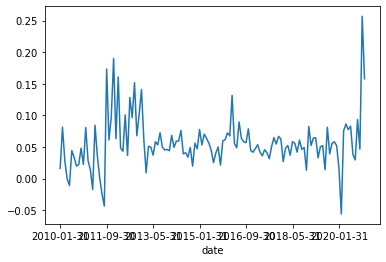

In [349]:
returns.plot()